In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=57f0d01f563a9d16ba11572eb496cd5a4f8dcddba629ba559e64d10860c38b01
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import chess
import random
import numpy as np
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


Total Games: 1000
Agent 1 (White) Wins: 126
Agent 2 (Black) Wins: 77
Draws: 797
Losses for Agent 1 (White): 77
Losses for Agent 2 (Black): 126
Average Reward for Agent 1: 12.87
Average Reward for Agent 2: -12.87


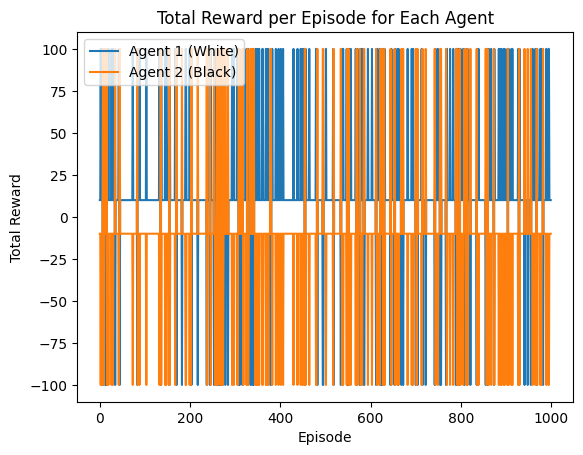

In [19]:
import chess
import random
import numpy as np
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

class RLAgent:
    def __init__(self, alpha=0.7, gamma=0.9, epsilon=0.5, max_q_values=100):
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.max_q_values = max_q_values  
        self.q_values = deque(maxlen=max_q_values)  
        self.total_reward = 0  
        self.num_games = 0  
        self.episode_rewards = []

        self.piece_values = dict(
            pawn=1,
            knight=3,
            bishop=3,
            rook=5,
            queen=9,
            king=100
        )

    def get_q_value(self, state, action):
        return next((q_value for q_state, q_action, q_value in self.q_values if q_state == state and q_action == action), 0.0)


    def update_q_value(self, state, action, next_state, reward):
        current_q = self.get_q_value(state, action)
        legal_actions = list(chess.Board(next_state).legal_moves)
        max_q = max((self.get_q_value(next_state, a) for a in legal_actions), default=0.0)
        new_q = current_q + self.alpha * (reward + self.gamma * max_q - current_q)
        self.q_values.append((state, action, new_q))


    def choose_action(self, state):
        return random.choice(list(chess.Board(state).legal_moves)) if random.random() < self.epsilon else self.get_best_action(chess.Board(state))


    
    def get_best_action(self, board):
        legal_actions = list(board.legal_moves)
        best_action = legal_actions[0]
        max_q = self.get_q_value(board.fen(), best_action)
        for action in legal_actions:
            q_value = self.get_q_value(board.fen(), action)
            if q_value > max_q:
                best_action = action
                max_q = q_value
        return best_action


    def get_reward(self, captured_piece):
        return 0 if captured_piece is None else self.piece_values.get(captured_piece.piece_type, 0)


    def play_game(self, opponent_agent):
        board = chess.Board()
        game_reward = 0  
        while not board.is_game_over():
            if board.turn == chess.WHITE:
                state = board.fen()
                action = self.choose_action(state)
                board.push(action)
                reward = 0

                captured_piece = board.piece_at(action.to_square)
                if captured_piece:
                    reward = self.get_reward(captured_piece)

                next_state = board.fen()
                self.update_q_value(state, action, next_state, reward)
                game_reward += reward  
            else:
                state = board.fen()
                action = opponent_agent.choose_action(state)
                board.push(action)
                reward = 0

                captured_piece = board.piece_at(action.to_square)
                if captured_piece:
                    reward = opponent_agent.get_reward(captured_piece)

                next_state = board.fen()
                opponent_agent.update_q_value(state, action, next_state, reward)
                game_reward += reward  

        result = board.result()
        if result == "1-0": game_reward += 100  
        elif result == "0-1": game_reward -= 100  
        else: game_reward += 10  

        return result, game_reward

agent1,agent2 = RLAgent(),RLAgent()

total_games = 1000
agent1_wins, agent2_wins, draws = 0, 0, 0
episode_rewards_agent1,episode_rewards_agent2 = [], []

for _ in tqdm(range(total_games)):
    agent1.total_reward,agent2.total_reward  = 0,0  
    result, game_reward = agent1.play_game(agent2)

    if result == "1-0": agent1_wins += 1
    elif result == "0-1": agent2_wins += 1
    else: draws += 1

    agent1.total_reward = game_reward  
    agent2.total_reward = -game_reward  

    episode_rewards_agent1.append(agent1.total_reward)
    episode_rewards_agent2.append(agent2.total_reward)

print(f"Total Games: {total_games}")
print(f"Agent 1 (White) Wins: {agent1_wins}")
print(f"Agent 2 (Black) Wins: {agent2_wins}")
print(f"Draws: {draws}")
print(f"Losses for Agent 1 (White): {total_games - agent1_wins - draws}")
print(f"Losses for Agent 2 (Black): {total_games - agent2_wins - draws}")
print(f"Average Reward for Agent 1: {np.mean(episode_rewards_agent1)}")
print(f"Average Reward for Agent 2: {np.mean(episode_rewards_agent2)}")

plt.plot(episode_rewards_agent1, label="Agent 1 (White)")
plt.plot(episode_rewards_agent2, label="Agent 2 (Black)")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode for Each Agent')
plt.legend()
plt.show()


In [20]:
import pickle

def save_agent(agent, filename="agent_model.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(agent.q_values, f)
    print(f"Agent's Q-values have been saved to {filename}")

save_agent(agent1)

Agent's Q-values have been saved to agent_model.pkl


In [21]:
!pip install stockfish

In [22]:
import os
import shutil
import chess
import random
from stockfish import Stockfish

In [23]:
KAGGLE = True

if KAGGLE:
    input_stockfish_path = "/kaggle/input/stockfish_ubuntu/other/default/1/stockfish-ubuntu-x86-64-avx2"
    stockfish_path = "/kaggle/working/stockfish"
    if not os.path.exists(stockfish_path):
        shutil.copy(input_stockfish_path, stockfish_path)
    os.chmod(stockfish_path, 0o755)
else:
    stockfish_path = "../../models/validation_stockfish/stockfish-windows-x86-64-avx2.exe"
    
stockfish = Stockfish(path=stockfish_path)
stockfish.set_skill_level(20)


In [24]:
def configure_stockfish_using_skill_level(skill_level):
    stockfish = Stockfish(path=stockfish_path)
    stockfish.set_skill_level(skill_level)
    return stockfish

def configure_stockfish_using_rating(elo_rating):
    stockfish = Stockfish(path=stockfish_path)
    stockfish.set_elo_rating(elo_rating)
    return stockfish

def play_single_game(agent, stockfish, max_moves=50):
    board = chess.Board()
    stockfish.set_fen_position(board.fen())

    for move_count in range(max_moves):
        if board.turn:
            move = agent.get_best_action(board)
        else:
            move = chess.Move.from_uci(stockfish.get_best_move())
        board.push(move)
        stockfish.set_fen_position(board.fen())

        if board.is_game_over():
            break 

    return board.result()

def evaluate_agent(agent, skill_levels, games_per_rating=20):
    results = []

    for level in skill_levels:
        stockfish = configure_stockfish_using_skill_level(level)
        outcomes = {"Wins": 0, "Losses": 0, "Draws": 0}

        for _ in range(games_per_rating):
            result = play_single_game(agent, stockfish)
            if result == "1-0":
                outcomes["Wins"] += 1
            elif result == "0-1":
                outcomes["Losses"] += 1
            else:
                outcomes["Draws"] += 1

        win_rate = (outcomes["Wins"] + 0.5 * outcomes["Draws"]) / games_per_rating
        outcomes["Win Rate"] = win_rate
        outcomes["Stockfish Level"] = level
        results.append(outcomes)

        print(f"Elo {level}: {outcomes}")

    return results

stockfish_skill_levels = [1,5,10,15] 
results = evaluate_agent(agent1, stockfish_skill_levels)

Elo 1: {'Wins': 0, 'Losses': 12, 'Draws': 8, 'Win Rate': 0.2, 'Stockfish Level': 1}
Elo 5: {'Wins': 0, 'Losses': 5, 'Draws': 15, 'Win Rate': 0.375, 'Stockfish Level': 5}
Elo 10: {'Wins': 0, 'Losses': 5, 'Draws': 15, 'Win Rate': 0.375, 'Stockfish Level': 10}
Elo 15: {'Wins': 0, 'Losses': 18, 'Draws': 2, 'Win Rate': 0.05, 'Stockfish Level': 15}
